<a href="https://colab.research.google.com/github/joshivaibhavii/Revolutionizing-Farming-with-Drone-Technology/blob/main/Cropdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
import imghdr
from tensorflow.keras import models, layers
from IPython.display import HTML

<ipython-input-1-f08a6f611ead>:5: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
BATCH_SIZE = 8
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

#Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantdisease


In [5]:
!pip install kaggle

In [6]:
!kaggle datasets download -d emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown


In [7]:
from zipfile import ZipFile
file_name = "/content/plantdisease.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [8]:
trainingdataset=tf.keras.preprocessing.image_dataset_from_directory('/content/PlantVillage',
seed=123,
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [10]:
class_names = trainingdataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

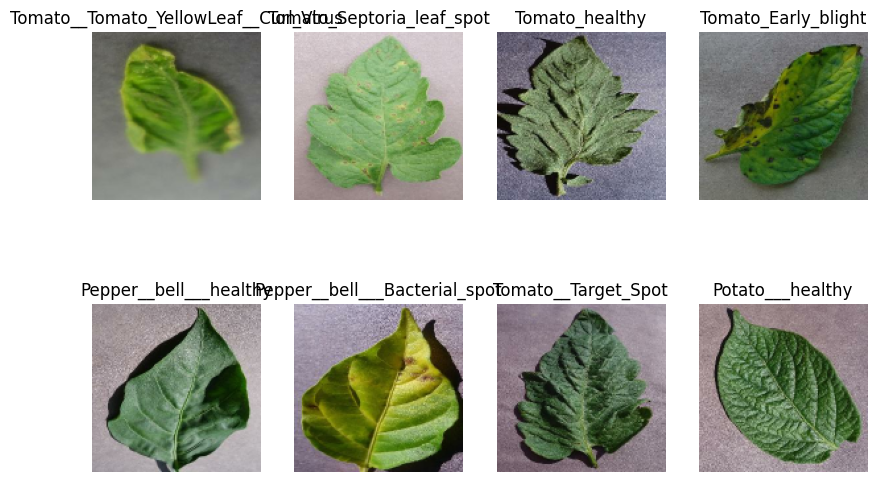

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in trainingdataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(trainingdataset)

2580

In [13]:
train_size = 0.8
len(trainingdataset)*train_size

2064.0

In [14]:
train_ds = trainingdataset.take(30)
len(train_ds)

30

In [15]:
test_ds = trainingdataset.skip(30)
len(test_ds)

2550

In [16]:
val_size=0.1
len(trainingdataset)*val_size

258.0

In [17]:
val_ds = trainingdataset.take(3)
len(val_ds)

3

In [18]:
len(train_ds)

30

In [19]:
len(test_ds)

2550

In [20]:
len(val_ds)

3

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(trainingdataset)

In [24]:
len(train_ds)

2064

In [25]:
len(val_ds)

258

In [26]:
len(test_ds)

258

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [29]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


In [30]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze base model to save memory

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax')  # Adjust classes
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (8, 128, 128, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (8, 126, 126, 32)      │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (8, 63, 63, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (8, 61, 61, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (8, 30, 30, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (8, 57600)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (8, 64)                │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (8, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,051 (14.14 MB)

 Trainable params: 3,706,051 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
import os

dataset_path = "/content/PlantVillage"  # Change if needed

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):  # Check if it's a folder
        print(f"Category: {category}, Number of files: {len(os.listdir(category_path))}")


Category: Tomato_Septoria_leaf_spot, Number of files: 1771
Category: Tomato_Late_blight, Number of files: 1909
Category: Tomato__Target_Spot, Number of files: 1404
Category: Tomato_Leaf_Mold, Number of files: 952
Category: Tomato_Bacterial_spot, Number of files: 2127
Category: Tomato_healthy, Number of files: 1591
Category: Potato___Late_blight, Number of files: 1000
Category: Potato___Early_blight, Number of files: 1000
Category: Tomato__Tomato_mosaic_virus, Number of files: 373
Category: Tomato__Tomato_YellowLeaf__Curl_Virus, Number of files: 3209
Category: Tomato_Early_blight, Number of files: 1000
Category: Potato___healthy, Number of files: 152
Category: Pepper__bell___Bacterial_spot, Number of files: 997
Category: Pepper__bell___healthy, Number of files: 1478
Category: Tomato_Spider_mites_Two_spotted_spider_mite, Number of files: 1676


In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 49s 24ms/step - accuracy: 0.0493 - loss: nan - val_accuracy: 0.0547 - val_loss: nan
Epoch 2/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 49s 24ms/step - accuracy: 0.0491 - loss: nan - val_accuracy: 0.0547 - val_loss: nan
Epoch 3/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 49s 24ms/step - accuracy: 0.0485 - loss: nan - val_accuracy: 0.0547 - val_loss: nan
Epoch 4/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 50s 24ms/step - accuracy: 0.0466 - loss: nan - val_accuracy: 0.0547 - val_loss: nan
Epoch 5/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.0500 - loss: nan - val_accuracy: 0.0547 - val_loss: nan
Epoch 6/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 50s 24ms/step - accuracy: 0.0487 - loss: nan - val_accuracy: 0.0547 - val_loss: nan
Epoch 7/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.0467 - loss: nan - val_accuracy: 0.0547 - val_loss: nan
Epoch 8/50
2064/2064 ━━━━━━━━━━━━━━━━━━━━ 49s 24ms/step - accuracy: 0.0503 - loss: nan - val_accuracy: 0.0547 - val_lo

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    print("NaN in images:", np.isnan(images.numpy()).any())
    print("NaN in labels:", np.isnan(labels.numpy()).any())


In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
scores = model.evaluate(test_ds)

258/258 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.0554 - loss: nan


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: Tomato_healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
predicted label: Pepper__bell___Bacterial_spot


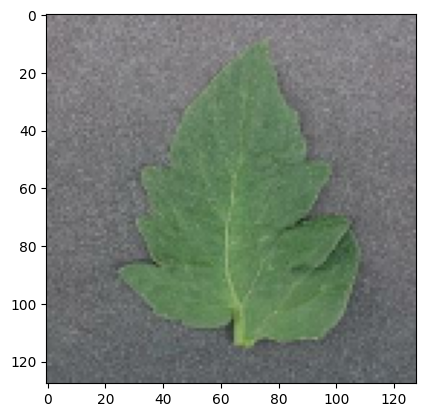

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])